In [168]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import sys

rcParams["figure.figsize"] = [14, 10]
rcParams["figure.dpi"] = 100

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 20}

matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


/Users/marcel/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Load EN4 data

In [36]:
path = '/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/OI_L09_1989_2020/*.nc'

oi_data = xr.open_mfdataset(path)

Cut on lats to only include up to 20S

In [37]:
oi_data = oi_data.sel(lat=slice(oi_data.lat.min(), 0), depth=oi_data.depth[0])

Resample data to yearly to get a yearly trend line

In [23]:
oi_data_yr = oi_data.resample(time="1Y").mean()

Define calculation for the trendline

In [38]:
np.seterr(divide='ignore', invalid='ignore')

data = oi_data

trend_T = np.ndarray([len(data.lat), len(data.lon)])
trend_S = np.ndarray([len(data.lat), len(data.lon)])

lons = data.lon.values
lats = data.lat.values

xs = np.arange(len(data.time))

t = data.temperature.values
s = data.salinity.values

In [39]:
for i, ln in enumerate(lons):
    
    for ii, lt in enumerate(lats):
        
        yt = t[:, ii, i]
        
        if np.nanmin(yt) > 0:
        
            ys = s[:, ii, i]
            
            trend_T[ii, i] = np.polyfit(xs, yt, 1)[0]
            trend_S[ii, i] = np.polyfit(xs, ys, 1)[0]
            
        else:
            
            trend_T[ii, i] = np.NaN
            trend_S[ii, i] = np.NaN


/Users/marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


Get the maximum sea ice 

In [9]:
import pandas as pd
seaice = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/asi*.hdf', 
                          concat_dim=pd.date_range(start='2018-01-01', end='2019-03-31', freq='D'))

seaice_lnlt = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/LongitudeLatitudeGrid-s6250-Antarctic.hdf')

In [10]:
seaice = seaice.sel(concat_dim=slice('2018-09-01', '2018-09-30'))

seaice = seaice.resample(concat_dim='1M').mean().squeeze()

In [11]:
seaice = seaice.rename({'concat_dim': 'time', 'ASI Ice Concentration': 'si_conc'})
seaice = seaice.assign_coords(lon=(["x", "y"], np.array(seaice_lnlt.Longitudes)))
seaice = seaice.assign_coords(lat=(["x", "y"], np.array(seaice_lnlt.Latitudes)))
seaice = seaice.assign(si=(["x", "y"], seaice.si_conc.values))

/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [12]:
from scipy.interpolate import griddata as g
from tqdm import tqdm_notebook

X = np.arange(-180, 180.5, 0.5)
Y = np.arange(-80, -49.5, 0.5)

x, y = np.meshgrid(X,Y)

x_, y_ = np.ravel(seaice.lon), np.ravel(seaice.lat)
x_[x_>180] = x_[x_>180]-360
 
si = np.ravel(seaice.si.values)
sic_new = g((y_, x_), si, (y, x), method='linear')
       
sic_new[sic_new==0] = np.NaN
sic_new = np.ma.masked_invalid(sic_new)


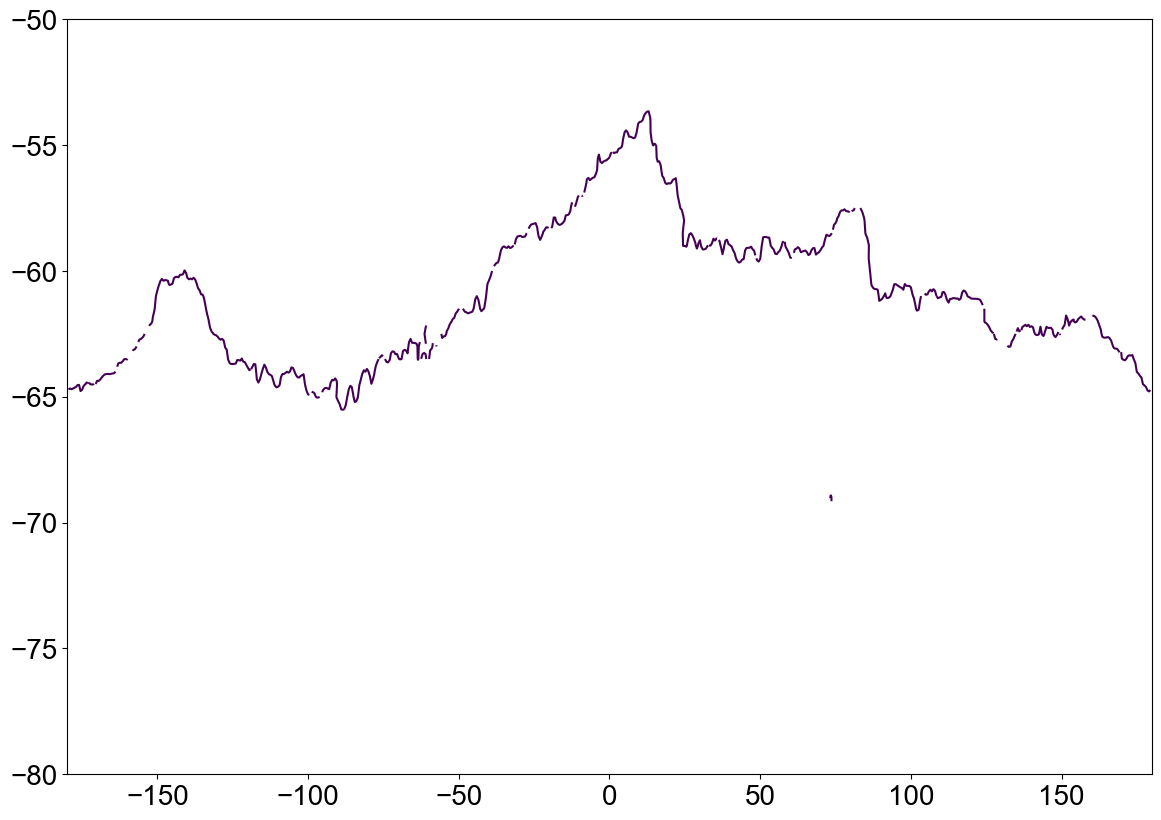

In [92]:
CS=contour(X, Y, sic_new, levels=['15'])
CS

In [109]:
list(ln)

[15.49712883379467,
 14.999999999999998,
 14.623390179503147,
 14.5,
 14.434575369185648,
 14.0,
 13.6440875642278,
 13.585413379477728,
 13.5,
 13.0,
 12.5,
 12.0,
 11.5,
 11.015576992191468,
 11.0,
 10.5,
 10.0,
 9.5,
 9.003853746853643,
 9.0,
 8.5,
 8.0,
 7.5,
 7.0,
 6.5,
 6.026338401985715,
 6.0,
 5.5,
 5.0,
 4.995072643439303,
 4.5,
 4.232927217856707,
 4.0,
 3.5,
 3.0,
 2.5,
 2.0,
 1.5,
 1.2343657262698762]

In [124]:
lons = []; lats = []

for i in range(len(CS.allsegs[0])):

    ln = CS.allsegs[0][i][:, 0]
    lt = CS.allsegs[0][i][:, 1]
    
    if i == 0:
        
        lons = ln
        lats = lt
        
    if i > 0:
        
        lons = np.append(lons, ln)
        lats = np.append(lats, lt)


In [132]:
i = np.argsort(lons)

lons = lons[i]
lats = lats[i]

i = lats > -66

lons = lons[i]
lats = lats[i]

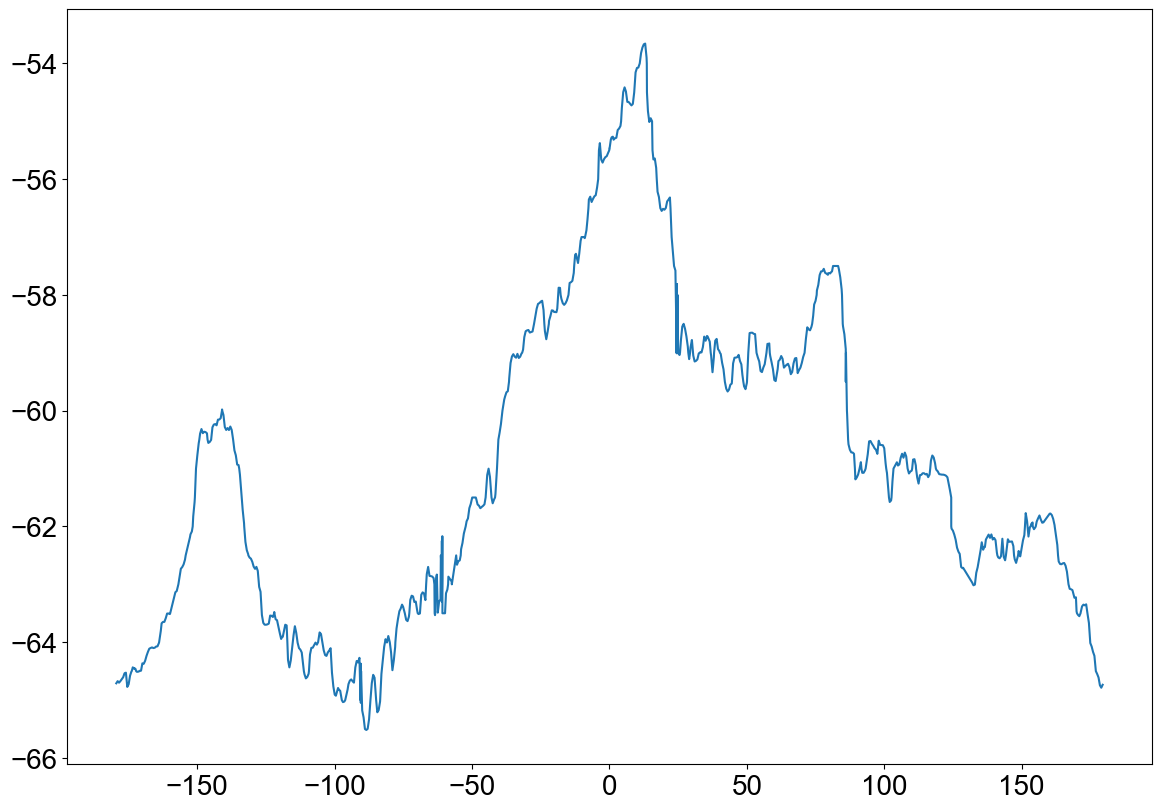

In [133]:
plot(lons, lats)

In [55]:
import scipy.interpolate as sci

In [ ]:
sci.griddata()

In [64]:
dat0[0]

array([[ 72.98979966, -68.98979966],
       [ 73.        , -68.99067903],
       [ 73.5       , -68.92010728],
       [ 73.64834336, -69.        ],
       [ 73.64913745, -69.14913745]])

In [81]:
dat0[0]

array([[ 96.62764808, -65.1379385 ],
       [ 96.63441539, -65.14436381]])

In [86]:
dat0[13]

array([[-57.61670523, -61.95087597],
       [-57.5857795 , -61.88559311],
       [-57.72992736, -61.8665141 ],
       ...,
       [-46.01050271, -60.45449487],
       [-45.94821256, -60.49998501],
       [-46.00249544, -60.52909465]])

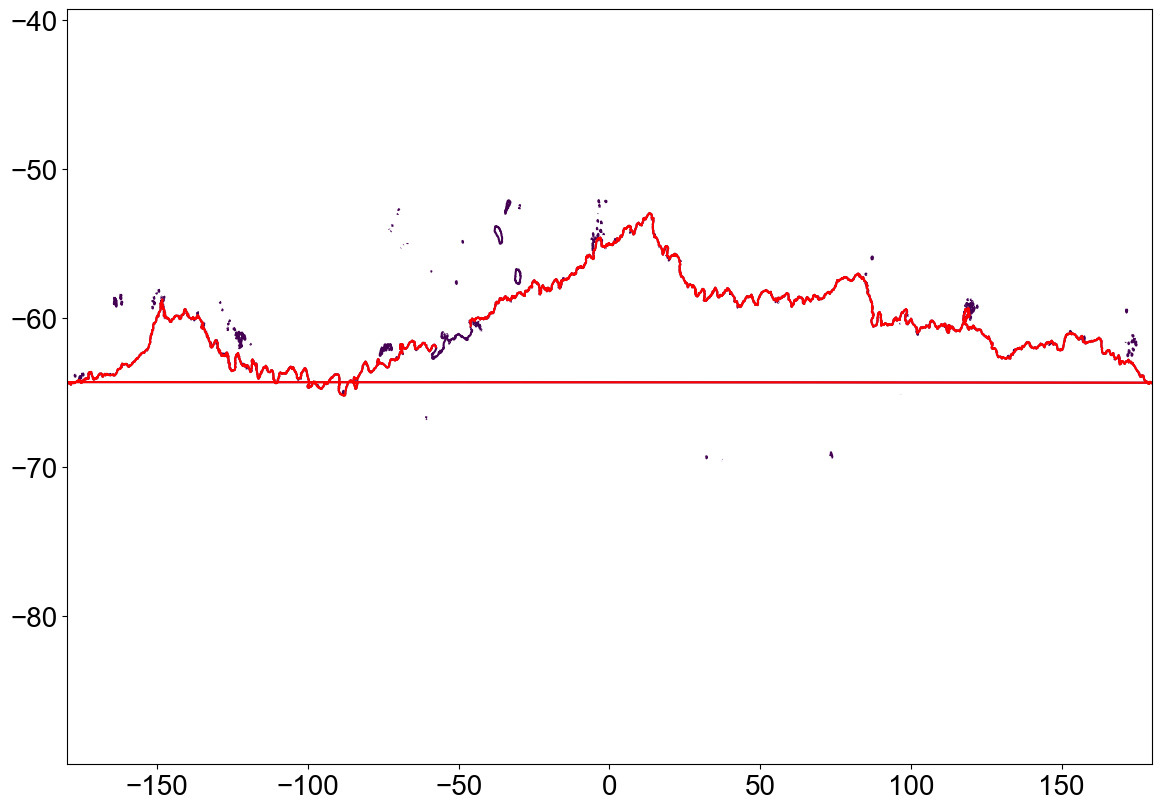

In [87]:
CS=contour(seaice.lon, seaice.lat, seaice.si.values, levels=['0.15'])
dat0 = CS.allsegs[0][:]
j = [len(dat0[i]) for i in range(len(dat0))]
dat0 = CS.allsegs[0][argmax(j)]

plt.plot(dat0[:,0],dat0[:,1], c='r')
# stf1 = dat0


### Figure: Temperature and Salinity Trends Map

In [40]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


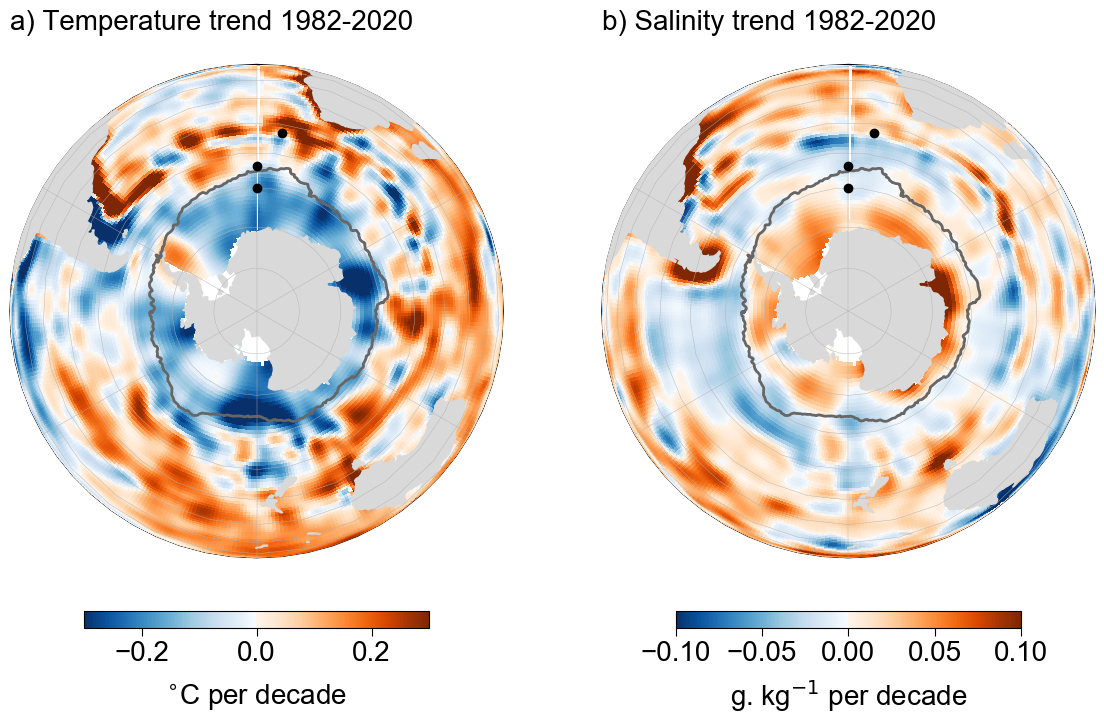

In [169]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure()

ax= plt.subplot(1,2,1, projection=ccrs.Orthographic(0, -90))

im=ax.pcolormesh(data.lon, data.lat, trend_T*10*12, transform=ccrs.PlateCarree(), 
              vmin=-0.3, vmax=0.3, cmap=newcmp, zorder=4)
ax.add_feature(cfeature.LAND, color='0.85', zorder=5)
ax.gridlines(zorder=6, linewidth=0.3)
c=colorbar(mappable=im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.07)
c.set_label('$^{\circ}$C per decade', labelpad=11)
title('a) Temperature trend 1982-2020', loc='left', fontsize=20, pad=25)
ax.scatter([0, 0, 8], [-60, -54, -43], c='k', transform=ccrs.PlateCarree(), zorder=10)
ax.plot(lons, lats, c='0.4', zorder=9, transform=ccrs.PlateCarree(), lw=2)

# subplot of the salinity trend statistics

ax = plt.subplot(1,2,2, projection=ccrs.Orthographic(0, -90))

im = ax.pcolormesh(data.lon, data.lat, trend_S*10*12, transform=ccrs.PlateCarree(), 
              vmin=-0.1, vmax=0.1, cmap=newcmp, zorder=4)
ax.add_feature(cfeature.LAND, color='0.85', zorder=5)
ax.gridlines(zorder=6, linewidth=0.3)
c=colorbar(mappable=im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.07)
c.set_label('g. kg$^{-1}$ per decade', labelpad=8)
title('b) Salinity trend 1982-2020', loc='left', fontsize=20, pad=25)
ax.plot(lons, lats, c='0.4', zorder=9, transform=ccrs.PlateCarree(), lw=2)

ax.scatter([0, 0, 8], [-60, -54, -43], c='k', transform=ccrs.PlateCarree(), zorder=10)

Study site trends

In [165]:
rcParams["figure.figsize"] = [14, 8]
plt.rcParams["xtick.major.size"] = 6
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 12}

matplotlib.rc('font', **font)

def plot_trend(ys, xs, ax):

    trend = np.polyfit(xs,ys,1)
    ax.plot(ys.time,ys,c='0.5')
    trendpoly = np.poly1d(trend) 
    ax.plot(ys.time,trendpoly(xs), c='r')
#     ax.set_title(str(trend[0])+'x + '+str(trend[1]), fontsize=12)
    
    
    return np.round(trend[0], 4)

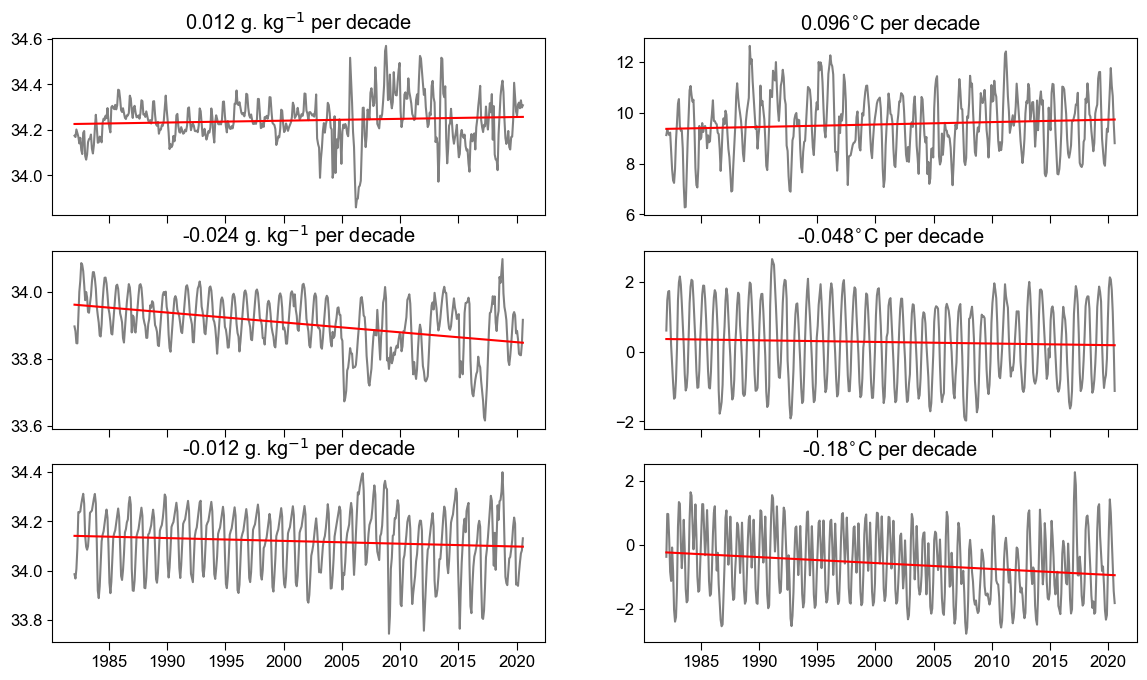

In [166]:
fig, ax = subplots(3, 2, sharex=True)

xs = np.arange(len(ys))

for i, a in enumerate(ax):
    
    if i==0:
        
        ys = oi_data.   salinity.sel(lat=-43, lon=8)
        yt = oi_data.temperature.sel(lat=-43, lon=8)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1])
        
        a[0].set_title(str(ts*10*12) + ' g. kg$^{-1}$ per decade')
        a[1].set_title(str(tt*10*12) + '$^{\circ}$C per decade')
        
    if i==1:
        
        ys = oi_data.   salinity.sel(lat=-54, lon=1)
        yt = oi_data.temperature.sel(lat=-54, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title(str(ts*10*12) + ' g. kg$^{-1}$ per decade')
        a[1].set_title(str(tt*10*12) + '$^{\circ}$C per decade')
        
    if i==2:
        
        ys = oi_data.   salinity.sel(lat=-60, lon=1)
        yt = oi_data.temperature.sel(lat=-60, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title(str(ts*10*12) + ' g. kg$^{-1}$ per decade')
        a[1].set_title(str(tt*10*12) + '$^{\circ}$C per decade')
        